In [ ]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

Files already downloaded and verified
Files already downloaded and verified
torch.Size([16, 3, 32, 32])
torch.Size([16])


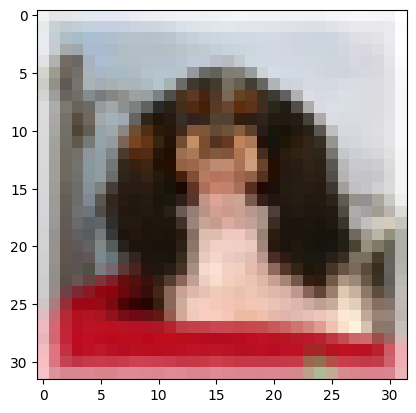

In [ ]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print the shape of the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# print one of the images
img = images[0]
img = img / 2 + 0.5     # unnormalize

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()




# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5


        def convbn(channels_in,channels_out,kernel_size,stride=1,padding_size=0):
            return nn.Sequential(
                nn.Conv2d(channels_in,channels_out,kernel_size,stride=stride,padding=padding_size),
                nn.ReLU(True),
                nn.BatchNorm2d(channels_out))

        self.model = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.model.parameters()]))

    def forward(self, x):
        return self.model(x)

In [ ]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        if epoch == 40:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.005
        if epoch == 80:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)

        # save the model
        torch.save(model.state_dict(), f'{model_name}_{epoch}.ckpt')
    return val_error,val_loss_values,train_error,train_loss_values


In [17]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.5189
Epoch [1/100], Step [2000/3125], Loss: 0.9154
Epoch [1/100], Step [3000/3125], Loss: 1.6051
Accuracy of the network on the test images: 56.67 %
Epoch [2/100], Step [1000/3125], Loss: 0.9281
Epoch [2/100], Step [2000/3125], Loss: 1.0996
Epoch [2/100], Step [3000/3125], Loss: 0.7092
Accuracy of the network on the test images: 68.01 %
Epoch [3/100], Step [1000/3125], Loss: 0.5287
Epoch [3/100], Step [2000/3125], Loss: 0.5972
Epoch [3/100], Step [3000/3125], Loss: 0.5526
Accuracy of the network on the test images: 76.36 %
Epoch [4/100], Step [1000/3125], Loss: 0.7889
Epoch [4/100], Step [2000/3125], Loss: 0.0689
Epoch [4/100], Step [3000/3125], Loss: 0.5654
Accuracy of the network on the test images: 79.26 %
Epoch [5/100], Step [1000/3125], Loss: 0.6113
Epoch [5/100], Step [2000/3125], Loss: 0.4935
Epoch [5/100], Step [3000/3125], Loss: 0.7261
Accuracy of the network on the test images: 79.74 %
Epoch [6/100], Step [1000